# Fitzhugh-Nagumo ODE: PINN vs. Finite Difference

This notebook solves the Fitzhugh-Nagumo equations and compares a Physics-Informed Neural Network (PINN) solution to a traditional Finite Difference Method (FDM) solution.

## Equations
$$
\begin{aligned}
\frac{dv}{dt} &= v - \frac{v^3}{3} - w + I_{ext} \\
\frac{dw}{dt} &= \frac{1}{\tau} (v + a - b w)
\end{aligned}
$$

In [79]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed
torch.manual_seed(1234)
np.random.seed(1234)

# Device configuration (L-BFGS requires float64, which is not supported on MPS)
# We will force CPU for this notebook to ensure compatibility.
device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Finite Difference Method (FDM) Solver

We'll use the 4th-order Runge-Kutta (RK4) method to generate a high-accuracy ground truth solution.

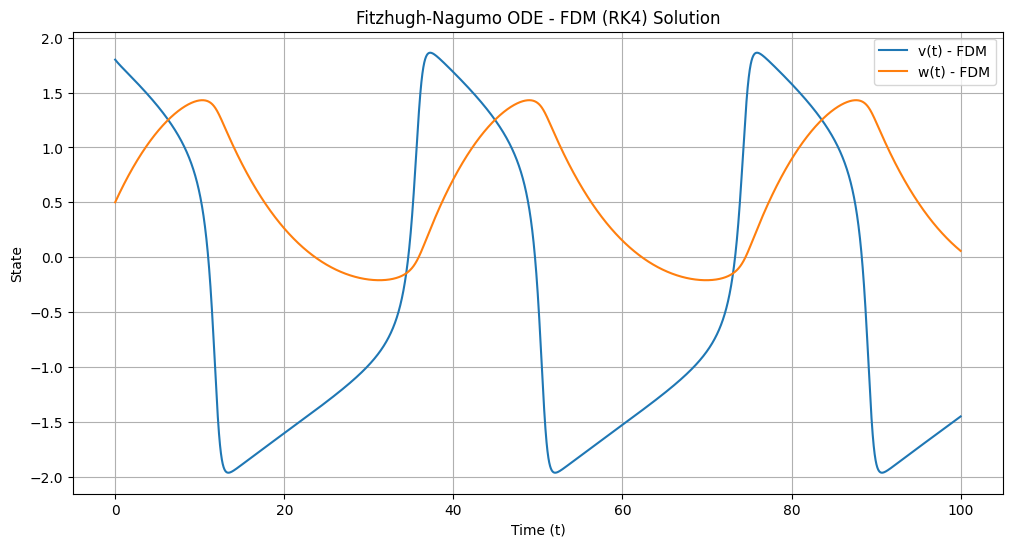

In [80]:
# Define the Fitzhugh-Nagumo ODE system
def fitzhugh_nagumo_odes(t, y, a, b, tau, I_ext):
    v, w = y
    dvdt = v - (v**3 / 3) - w + I_ext
    dwdt = (1 / tau) * (v + a - b * w)
    return np.array([dvdt, dwdt])

# RK4 Solver
def rk4_step(f, t, y, h, a, b, tau, I_ext):
    k1 = h * f(t, y, a, b, tau, I_ext)
    k2 = h * f(t + 0.5*h, y + 0.5*k1, a, b, tau, I_ext)
    k3 = h * f(t + 0.5*h, y + 0.5*k2, a, b, tau, I_ext)
    k4 = h * f(t + h, y + k3, a, b, tau, I_ext)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6

# Parameters
a = 0.7
b = 0.8
tau = 12.5
I_ext = 0.545

# Time domain
t_start = 0.0
t_end = 100.0
dt = 0.01
n_steps = int((t_end - t_start) / dt)
t_fdm = np.linspace(t_start, t_end, n_steps + 1)

# Initial conditions
v0 = 1.8
w0 = 0.5
y0 = np.array([v0, w0])

# Solve the ODEs
v_fdm = np.zeros(n_steps + 1)
w_fdm = np.zeros(n_steps + 1)
v_fdm[0], w_fdm[0] = y0

y = y0
for i in range(n_steps):
    y = rk4_step(fitzhugh_nagumo_odes, t_fdm[i], y, dt, a, b, tau, I_ext)
    v_fdm[i+1], w_fdm[i+1] = y

# Plot the FDM solution
plt.figure(figsize=(12, 6))
plt.plot(t_fdm, v_fdm, label='v(t) - FDM')
plt.plot(t_fdm, w_fdm, label='w(t) - FDM')
plt.title('Fitzhugh-Nagumo ODE - FDM (RK4) Solution')
plt.xlabel('Time (t)')
plt.ylabel('State')
plt.legend()
plt.grid(True)
plt.show()

## 2. Single PINN Solver (Baseline)

In [81]:
# PINN architecture
class PINN(nn.Module):
    def __init__(self, layers, t_start, t_end):
        super(PINN, self).__init__()
        # Store normalization constants
        self.t_start = t_start
        self.t_end = t_end
        
        # Build the network
        self.net = nn.Sequential()
        for i in range(len(layers) - 1):
            linear = nn.Linear(layers[i], layers[i+1])
            # Xavier initialization for weights
            nn.init.xavier_normal_(linear.weight)
            nn.init.zeros_(linear.bias)
            self.net.add_module(f'linear_{i}', linear)
            if i < len(layers) - 2:
                self.net.add_module(f'tanh_{i}', nn.Tanh())

    def forward(self, t):
        # Normalize input time to the range [-1, 1] for better training stability
        t_normalized = 2.0 * (t - self.t_start) / (self.t_end - self.t_start) - 1.0
        return self.net(t_normalized)

# --- Re-architect the training loop for L-BFGS ---
# Parameters from the FDM section are used here: a, b, tau, I_ext, v0, w0, t_start, t_end

# Training data
t_train = torch.linspace(t_start, t_end, 1000, dtype=torch.double, requires_grad=True, device=device).view(-1, 1)
y0_torch = torch.tensor([v0, w0], dtype=torch.double, device=device)
t0_torch = torch.tensor([t_start], dtype=torch.double, device=device).view(-1, 1)

# PINN setup
layers = [1, 32, 32, 32, 32, 32, 32, 32, 32, 2] # 1 input (t), 2 outputs (v, w)
pinn_model_single = PINN(layers, t_start, t_end).to(device).to(torch.double)

# Optimizer: L-BFGS
optimizer = torch.optim.LBFGS(
    pinn_model_single.parameters(),
    lr=1.0,
    max_iter=2000,
    max_eval=2000,
    history_size=50,
    tolerance_grad=1e-7,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe"
)

# Global iteration counter
iteration = 0

# Loss function and closure for L-BFGS
def pde_loss(model, t, a, b, tau, I_ext):
    y = model(t)
    v, w = y[:, 0], y[:, 1]
    
    # First-order derivatives using automatic differentiation
    dv_dt = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    dw_dt = torch.autograd.grad(w, t, grad_outputs=torch.ones_like(w), create_graph=True)[0]
    
    # ODE residuals
    f_v = dv_dt - (v - v**3 / 3 - w + I_ext)
    f_w = dw_dt - (1 / tau) * (v + a - b * w)
    
    return torch.mean(f_v**2) + torch.mean(f_w**2)

def closure():
    global iteration
    optimizer.zero_grad()
    
    # PDE loss
    loss_pde = pde_loss(pinn_model_single, t_train, a, b, tau, I_ext)
    
    # Initial Condition loss
    y_pred_0 = pinn_model_single(t0_torch)
    loss_ic = torch.mean((y_pred_0 - y0_torch)**2)
    
    # Total loss
    loss = loss_pde + 100 * loss_ic # Weight IC loss more heavily
    
    loss.backward()
    
    iteration += 1
    if iteration % 100 == 0:
        print(f'Iter {iteration}, Loss: {loss.item():.6f}, PDE: {loss_pde.item():.6f}, IC: {loss_ic.item():.6f}')
        
    return loss

# Training loop
print("Starting training with L-BFGS...")
pinn_model_single.train()
start_time = time.time()
optimizer.step(closure)
training_time = time.time() - start_time
print(f'PINN training finished in {training_time:.5e} seconds')


# Get PINN predictions
t_test_single = torch.linspace(t_start, t_end, n_steps + 1, dtype=torch.double, device=device).view(-1, 1)
y_pinn_single = pinn_model_single(t_test_single).detach().cpu().numpy()
v_pinn_single = y_pinn_single[:, 0]
w_pinn_single = y_pinn_single[:, 1]


Starting training with L-BFGS...
Iter 100, Loss: 0.008144, PDE: 0.007699, IC: 0.000004
Iter 200, Loss: 0.003948, PDE: 0.003948, IC: 0.000000
Iter 300, Loss: 0.003216, PDE: 0.003216, IC: 0.000000
Iter 400, Loss: 0.003142, PDE: 0.003140, IC: 0.000000
Iter 500, Loss: 0.003123, PDE: 0.003123, IC: 0.000000
Iter 600, Loss: 0.003109, PDE: 0.003104, IC: 0.000000
Iter 700, Loss: 0.003090, PDE: 0.003089, IC: 0.000000
Iter 800, Loss: 0.003086, PDE: 0.003086, IC: 0.000000
Iter 900, Loss: 0.003079, PDE: 0.003079, IC: 0.000000
Iter 1000, Loss: 0.003076, PDE: 0.003076, IC: 0.000000
Iter 1100, Loss: 0.003076, PDE: 0.003076, IC: 0.000000
Iter 1200, Loss: 0.003076, PDE: 0.003076, IC: 0.000000
Iter 1300, Loss: 0.003076, PDE: 0.003076, IC: 0.000000
Iter 1400, Loss: 0.003076, PDE: 0.003076, IC: 0.000000
Iter 1500, Loss: 0.003076, PDE: 0.003076, IC: 0.000000
Iter 1600, Loss: 0.003076, PDE: 0.003076, IC: 0.000000
Iter 1700, Loss: 0.003076, PDE: 0.003076, IC: 0.000000
Iter 1800, Loss: 0.003076, PDE: 0.003076,

## 3. Time-Marching PINN Solver

To address the issue of different time scales (stiffness) in the Fitzhugh-Nagumo equations, we can use a **time-marching** or **domain decomposition** approach. Instead of using a single neural network for the entire time domain, we divide the domain into smaller, sequential windows.

A separate, smaller PINN is trained for each window. The initial condition for each window is the final state predicted by the PINN from the previous window. This allows each network to focus on learning the dynamics over a shorter, simpler time horizon, which can significantly improve accuracy for stiff ODEs.

In [82]:
# --- Time-Marching PINN ---

# Time-marching parameters
n_windows = 500 # Number of time windows
window_size = (t_end - t_start) / n_windows
max_iter_per_window = 100 # L-BFGS iterations per window

# Store results from each window
v_pinn_tm = np.array([])
w_pinn_tm = np.array([])
t_pinn_tm = np.array([])

# Initial condition for the first window
y0_window = torch.tensor([v0, w0], dtype=torch.double, device=device)

# Store total training time
total_training_time_tm = 0.0

print(f"Starting time-marching training with {n_windows} windows...")

pinn_model_single.eval() # Put original model in eval mode
tm_pinn_models = []

for i in range(n_windows):
    t_window_start = t_start + i * window_size
    t_window_end = t_start + (i + 1) * window_size
    print(f"\n--- Training window {i+1}/{n_windows}: t = [{t_window_start:.2f}, {t_window_end:.2f}] ---")

    # Training data for the current window
    # More points at the start of the window could help enforce the IC
    t_train_window = torch.linspace(t_window_start, t_window_end, 100, dtype=torch.double, requires_grad=True, device=device).view(-1, 1)
    t0_window = torch.tensor([t_window_start], dtype=torch.double, device=device).view(-1, 1)

    # PINN setup for the current window
    layers_window = [1, 32, 32, 2] # Smaller network for each window
    pinn_model_window = PINN(layers_window, t_window_start, t_window_end).to(device).to(torch.double)

    # Optimizer for the current window
    optimizer_window = torch.optim.LBFGS(
        pinn_model_window.parameters(),
        lr=1.0,
        max_iter=max_iter_per_window,
        max_eval=max_iter_per_window,
        history_size=50,
        tolerance_grad=1e-8,
        tolerance_change=1.0 * np.finfo(float).eps,
        line_search_fn="strong_wolfe"
    )

    # Reset global iteration counter for each window
    iteration = 0
    # Closure for the current window
    def closure_window():
        global iteration
        optimizer_window.zero_grad()
        
        # PDE loss
        loss_pde = pde_loss(pinn_model_window, t_train_window, a, b, tau, I_ext)
        
        # Initial Condition loss
        y_pred_0 = pinn_model_window(t0_window)
        loss_ic = torch.mean((y_pred_0 - y0_window)**2)
        
        # Total loss
        loss = loss_pde + 100 * loss_ic # Weight IC loss heavily
        
        loss.backward()
        
        iteration += 1
        if iteration % 100 == 0:
            print(f'Iter {iteration}, Loss: {loss.item():.6f}, PDE: {loss_pde.item():.6f}, IC: {loss_ic.item():.6f}')
            
        return loss

    # Train the model for the window
    pinn_model_window.train()
    start_time_window = time.time()
    optimizer_window.step(closure_window)
    end_time_window = time.time()
    total_training_time_tm += (end_time_window - start_time_window)
    tm_pinn_models.append(pinn_model_window)


    # Get predictions for the current window and store them
    n_steps_window = int(round(window_size / dt))
    t_test_window_np = np.linspace(t_window_start, t_window_end, n_steps_window + 1)
    
    t_test_window = torch.tensor(t_test_window_np, dtype=torch.double, device=device).view(-1, 1)
    y_pinn_window = pinn_model_window(t_test_window).detach().cpu().numpy()

    # Append results, avoiding duplicate time points
    if i == 0:
        t_pinn_tm = np.append(t_pinn_tm, t_test_window_np.flatten())
        v_pinn_tm = np.append(v_pinn_tm, y_pinn_window[:, 0])
        w_pinn_tm = np.append(w_pinn_tm, y_pinn_window[:, 1])
    else:
        t_pinn_tm = np.append(t_pinn_tm, t_test_window_np.flatten()[1:])
        v_pinn_tm = np.append(v_pinn_tm, y_pinn_window[1:, 0])
        w_pinn_tm = np.append(w_pinn_tm, y_pinn_window[1:, 1])

    # Set initial condition for the next window
    # We use the prediction from the trained model at the end of the current window
    t_end_window_tensor = torch.tensor([t_window_end], dtype=torch.double, device=device).view(-1, 1)
    y0_window = pinn_model_window(t_end_window_tensor).detach()
    print(f"End of window {i+1}, new IC: v={y0_window[0,0]:.4f}, w={y0_window[0,1]:.4f}")


print(f'\nTime-marching PINN training finished in {total_training_time_tm:.5e} seconds')

print(f"\nTotal points from FDM: {len(t_fdm)}")
print(f"Total points from Time-Marching PINN: {len(t_pinn_tm)}")

# Ensure arrays have the same length for comparison
min_len = min(len(v_fdm), len(v_pinn_tm))
v_fdm_comp = v_fdm[:min_len]
w_fdm_comp = w_fdm[:min_len]
v_pinn_tm = v_pinn_tm[:min_len]
w_pinn_tm = w_pinn_tm[:min_len]
t_fdm_comp = t_fdm[:min_len]
t_pinn_tm = t_pinn_tm[:min_len]

# Also align the single PINN results
min_len_single = min(len(v_fdm), len(v_pinn_single))
v_pinn_single = v_pinn_single[:min_len_single]
w_pinn_single = w_pinn_single[:min_len_single]
t_test_single = t_test_single[:min_len_single]

Starting time-marching training with 500 windows...

--- Training window 1/500: t = [0.00, 0.20] ---
Iter 100, Loss: 0.000013, PDE: 0.000013, IC: 0.000000
End of window 1, new IC: v=1.7811, w=0.5333

--- Training window 2/500: t = [0.20, 0.40] ---
Iter 100, Loss: 0.000006, PDE: 0.000006, IC: 0.000000
End of window 2, new IC: v=1.7635, w=0.5658

--- Training window 3/500: t = [0.40, 0.60] ---
Iter 100, Loss: 0.000003, PDE: 0.000003, IC: 0.000000
End of window 3, new IC: v=1.7468, w=0.5977

--- Training window 4/500: t = [0.60, 0.80] ---
Iter 100, Loss: 0.000002, PDE: 0.000002, IC: 0.000000
End of window 4, new IC: v=1.7305, w=0.6288

--- Training window 5/500: t = [0.80, 1.00] ---
Iter 100, Loss: 0.000015, PDE: 0.000015, IC: 0.000000
End of window 5, new IC: v=1.7145, w=0.6594

--- Training window 6/500: t = [1.00, 1.20] ---
Iter 100, Loss: 0.000001, PDE: 0.000001, IC: 0.000000
End of window 6, new IC: v=1.6986, w=0.6892

--- Training window 7/500: t = [1.20, 1.40] ---
Iter 100, Loss: 0

## 4. Comparison and Visualization

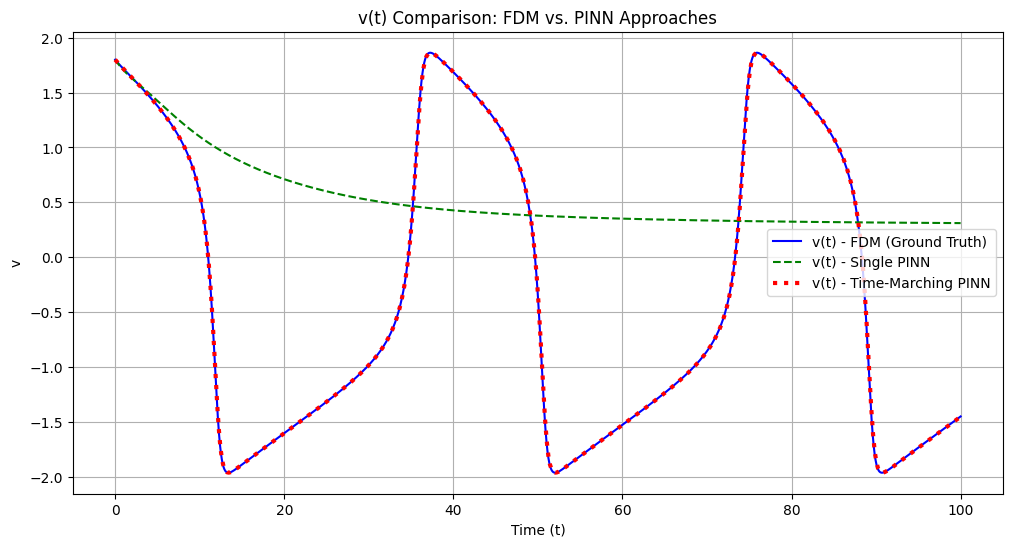

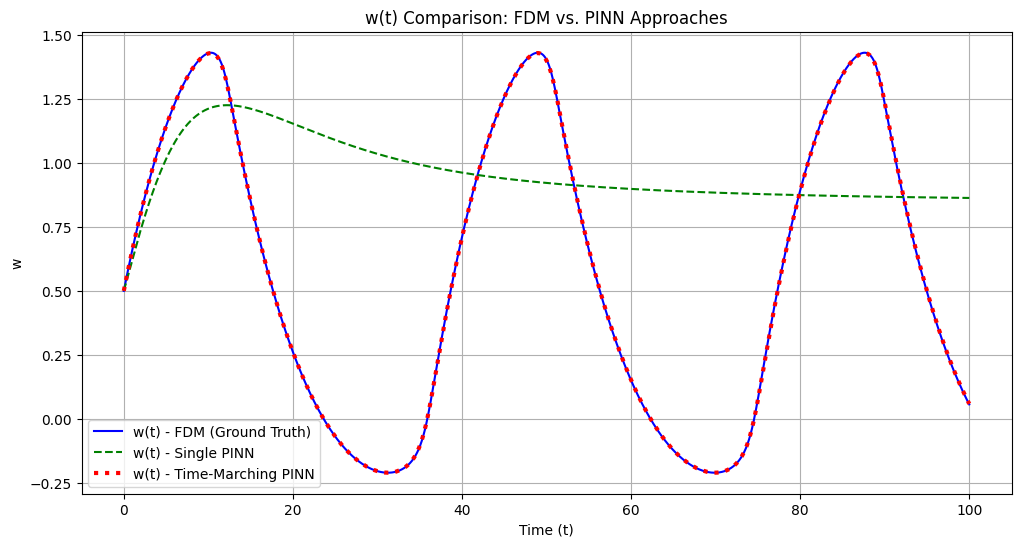

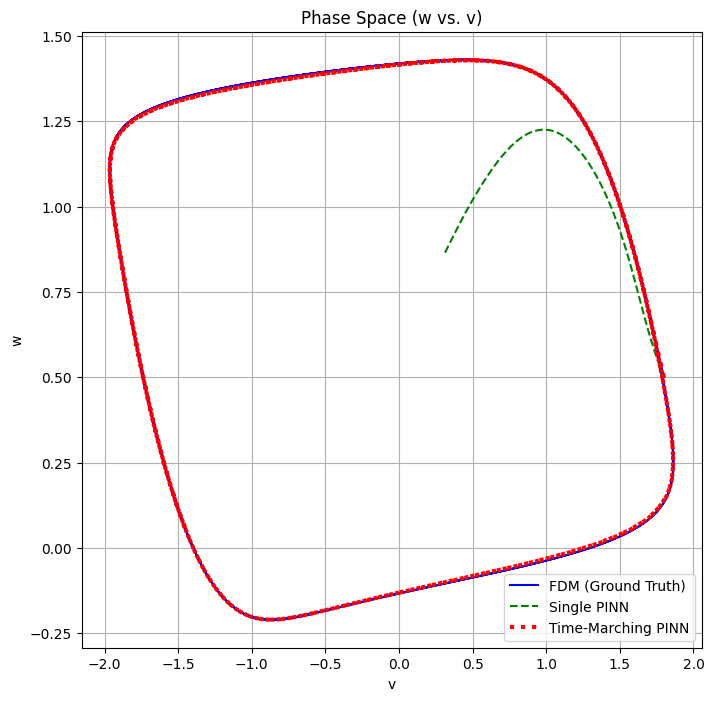

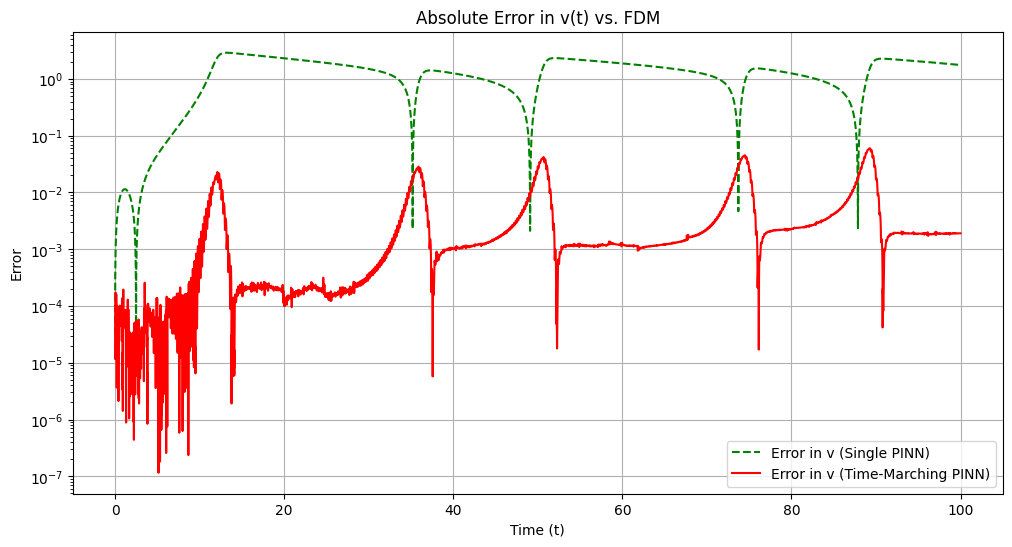

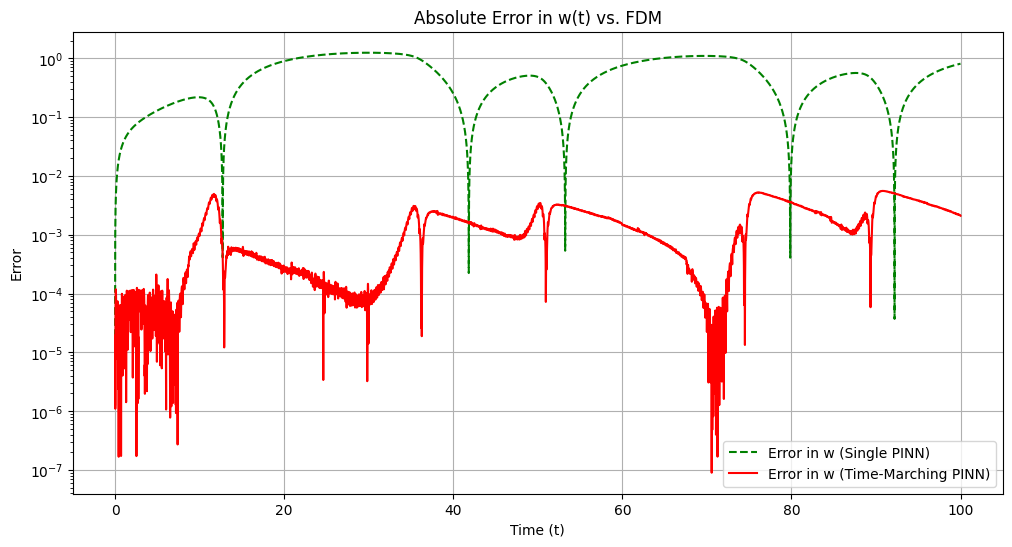

In [92]:
# Plot v(t) comparison
plt.figure(figsize=(12, 6))
plt.plot(t_fdm_comp, v_fdm_comp, 'b-', label='v(t) - FDM (Ground Truth)')
plt.plot(t_test_single.detach().numpy(), v_pinn_single, 'g--', label='v(t) - Single PINN')
plt.plot(t_pinn_tm, v_pinn_tm, 'r:', linewidth=3, label='v(t) - Time-Marching PINN')
plt.title('v(t) Comparison: FDM vs. PINN Approaches')
plt.xlabel('Time (t)')
plt.ylabel('v')
plt.legend()
plt.grid(True)
plt.show()

# Plot w(t) comparison
plt.figure(figsize=(12, 6))
plt.plot(t_fdm_comp, w_fdm_comp, 'b-', label='w(t) - FDM (Ground Truth)')
plt.plot(t_test_single.detach().numpy(), w_pinn_single, 'g--', label='w(t) - Single PINN')
plt.plot(t_pinn_tm, w_pinn_tm, 'r:', linewidth=3, label='w(t) - Time-Marching PINN')
plt.title('w(t) Comparison: FDM vs. PINN Approaches')
plt.xlabel('Time (t)')
plt.ylabel('w')
plt.legend()
plt.grid(True)
plt.show()

# Plot phase space
plt.figure(figsize=(8, 8))
plt.plot(v_fdm_comp, w_fdm_comp, 'b-', label='FDM (Ground Truth)')
plt.plot(v_pinn_single, w_pinn_single, 'g--', label='Single PINN')
plt.plot(v_pinn_tm, w_pinn_tm, 'r:', linewidth=3, label='Time-Marching PINN')
plt.title('Phase Space (w vs. v)')
plt.xlabel('v')
plt.ylabel('w')
plt.legend()
plt.grid(True)
plt.show()

# Plot error
v_error_single = np.abs(v_fdm_comp[:len(v_pinn_single)] - v_pinn_single)
w_error_single = np.abs(w_fdm_comp[:len(w_pinn_single)] - w_pinn_single)
v_error_tm = np.abs(v_fdm_comp - v_pinn_tm)
w_error_tm = np.abs(w_fdm_comp - w_pinn_tm)

plt.figure(figsize=(12, 6))
plt.plot(t_fdm_comp[:len(v_error_single)], v_error_single, 'g--', label='Error in v (Single PINN)')
plt.plot(t_fdm_comp, v_error_tm, 'r-', label='Error in v (Time-Marching PINN)')
plt.title('Absolute Error in v(t) vs. FDM')
plt.xlabel('Time (t)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t_fdm_comp[:len(w_error_single)], w_error_single, 'g--', label='Error in w (Single PINN)')
plt.plot(t_fdm_comp, w_error_tm, 'r-', label='Error in w (Time-Marching PINN)')
plt.title('Absolute Error in w(t) vs. FDM')
plt.xlabel('Time (t)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()